In [2]:
%cd ..

/Users/pedrobedmar/GoogleDrive/MASTER_BIG_DATA/tfm/code


In [25]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dask.distributed import LocalCluster, Client

from etl.esios.provider import ESIOSDataProvider
from etl.generic_provider import GenericDataProvider
import lab.functions as func

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.dummy import DummyRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import ShuffleSplit

from sktime.forecasting.compose import make_reduction
from sktime.forecasting.model_selection import SlidingWindowSplitter, ExpandingWindowSplitter, temporal_train_test_split
from sktime.forecasting.compose import ForecastingPipeline
from sktime.forecasting.arima import AutoARIMA
from sktime.transformations.series.summarize import WindowSummarizer
from sktime.utils.plotting import plot_series
from sktime.forecasting.model_evaluation import evaluate
from sktime.performance_metrics.forecasting import mean_absolute_error, mean_absolute_percentage_error, MeanAbsoluteScaledError, mean_absolute_scaled_error

SEED=0
np.random.seed(SEED)

In [5]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

In [6]:
esios_provider = ESIOSDataProvider()
esios_tickers = esios_provider.get_tickers()
print(esios_tickers)

investingdotcom_tickers = ["DAILY_TTF_PRICE", "MONTHLY_TTF_PRICE"]
investingdotcom_provider = GenericDataProvider("datalake/clean/investingdotcom/", want_metadata=False, tickers=investingdotcom_tickers)
print(investingdotcom_tickers)

marketwatch_tickers = ["DAILY_COAL_PRICE"]
marketwatch_provider = GenericDataProvider("datalake/clean/marketwatch/", want_metadata=False, tickers=marketwatch_tickers)
print(marketwatch_tickers)

icap_tickers = ["CO2_EUA_PRICE"]
icap_provider = GenericDataProvider("datalake/clean/ICAP/", want_metadata=False, tickers=icap_tickers)
print(icap_tickers)

['DEMANDA_REAL', 'GENERACIÓN_MEDIDA_TOTAL', 'GENERACIÓN_MEDIDA_EÓLICA', 'GENERACIÓN_MEDIDA_HIDRÁULICA', 'GENERACIÓN_MEDIDA_NUCLEAR', 'GENERACIÓN_MEDIDA_SOLAR', 'GENERACIÓN_MEDIDA_CICLO_COMBINADO', 'GENERACIÓN_MEDIDA_CARBÓN', 'PRECIO_MERCADO_SPOT_DIARIO']
['DAILY_TTF_PRICE', 'MONTHLY_TTF_PRICE']
['DAILY_COAL_PRICE']
['CO2_EUA_PRICE']


In [7]:
forecasting_horizon = 30
fh = list(range(1, forecasting_horizon+1))

window_lengths = [200, 300, 400, 500]
step_size = 60

In [6]:
def load_and_preprocess_daily_data_arima(start_index, end_index):
    esios_spot = esios_provider.get_series("PRECIO_MERCADO_SPOT_DIARIO", freq="H", start_index=start_index, end_index=end_index, resample_by="D", group_mode="mean")
    esios_df = esios_provider.get_all_series(freq="H", start_index=start_index, end_index=end_index, resample_by="D", group_mode="sum")
    ttf_df = investingdotcom_provider.get_series(investingdotcom_tickers[0], freq="D", start_index=start_index, end_index=end_index)
    coal_df = marketwatch_provider.get_series(marketwatch_tickers[0], freq="D", start_index=start_index, end_index=end_index)
    co2_df = icap_provider.get_series(icap_tickers[0], freq="D", start_index=start_index, end_index=end_index)

    contamination = 0.01
    esios_df = func.remove_outliers_isolation_forests(esios_df, contamination)

    X = esios_df.drop(['PRECIO_MERCADO_SPOT_DIARIO', 'GENERACIÓN_MEDIDA_TOTAL'], axis=1)
    X = pd.concat([X, ttf_df, coal_df, co2_df], axis=1)

    y = pd.Series(esios_spot)

    y_train, y_test, X_train, X_test = temporal_train_test_split(y, X, test_size=forecasting_horizon)

    return y_train, y_test, X_train, X_test

In [91]:
start_index="2021-04-01"
end_index="2023-03-31"

esios_df = esios_provider.get_all_series(freq="H", start_index=start_index, end_index=end_index, resample_by="D", group_mode="sum")
ttf_df = investingdotcom_provider.get_series(investingdotcom_tickers[0], freq="D", start_index=start_index, end_index=end_index)
coal_df = marketwatch_provider.get_series(marketwatch_tickers[0], freq="D", start_index=start_index, end_index=end_index)
co2_df = icap_provider.get_series(icap_tickers[0], freq="D", start_index=start_index, end_index=end_index)

X = esios_df.drop(['PRECIO_MERCADO_SPOT_DIARIO', 'GENERACIÓN_MEDIDA_TOTAL'], axis=1)

X = esios_df.drop(['PRECIO_MERCADO_SPOT_DIARIO', 'GENERACIÓN_MEDIDA_TOTAL'], axis=1)
X = pd.concat([X, ttf_df, coal_df, co2_df], axis=1)

y = esios_df['PRECIO_MERCADO_SPOT_DIARIO']

y_train, y_test, X_train, X_test = temporal_train_test_split(y, X, test_size=forecasting_horizon)

In [93]:
outlier_detector = IsolationForest(contamination=0.01)
scaler = StandardScaler()
pca = PCA(n_components=0.7)

clean_generation_feat = ['GENERACIÓN_MEDIDA_EÓLICA', 'GENERACIÓN_MEDIDA_HIDRÁULICA', 'GENERACIÓN_MEDIDA_NUCLEAR', 'GENERACIÓN_MEDIDA_SOLAR']
traditional_generation_feat = ['GENERACIÓN_MEDIDA_CICLO_COMBINADO', 'GENERACIÓN_MEDIDA_CARBÓN']
commodities_feat = ['DAILY_TTF_PRICE', 'DAILY_COAL_PRICE', 'CO2_EUA_PRICE']
rest_feat = ["DEMANDA_REAL"]

pca_pipeline = Pipeline([
    ('scale', scaler),
    ("pca", pca)
])

no_pca_pipeline = Pipeline([
    ('scale', scaler)
])

preprocessing = ColumnTransformer(
    transformers=[
        ("clean_generation", pca_pipeline, clean_generation_feat),
        ("traditional_generation", pca_pipeline, traditional_generation_feat),
        ("commodities", pca_pipeline, commodities_feat),
        ("rest", no_pca_pipeline, rest_feat)
    ]
)

pipeline = Pipeline(steps=[
    ("pca", preprocessing)
])

In [94]:
X_train_pca = pipeline.fit_transform(X_train)
X_train_pca = pd.DataFrame(X_train_pca, columns=pipeline.get_feature_names_out(), index=X_train.index)
X_test_pca = pipeline.transform(X_test)
X_test_pca = pd.DataFrame(X_test_pca, columns=pipeline.get_feature_names_out(), index=X_test.index)

In [95]:
best_window_length = 500
forecaster = AutoARIMA(maxiter=200)
forecaster.fit(y_train[best_window_length:], X=X_train_pca)

y_pred = forecaster.predict(X=X_test_pca, fh=list(range(1, forecasting_horizon + 1)))
print(mean_absolute_error(y_test, y_pred))
print(mean_absolute_percentage_error(y_test, y_pred))
print(mean_absolute_scaled_error(y_test, y_pred, y_train=y_train[best_window_length:]))

Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
Non-invertible starting MA parameters found. Using zeros as starting parameters.
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals


581.0496125139892
6.3833143949243984
1.1023672085534906


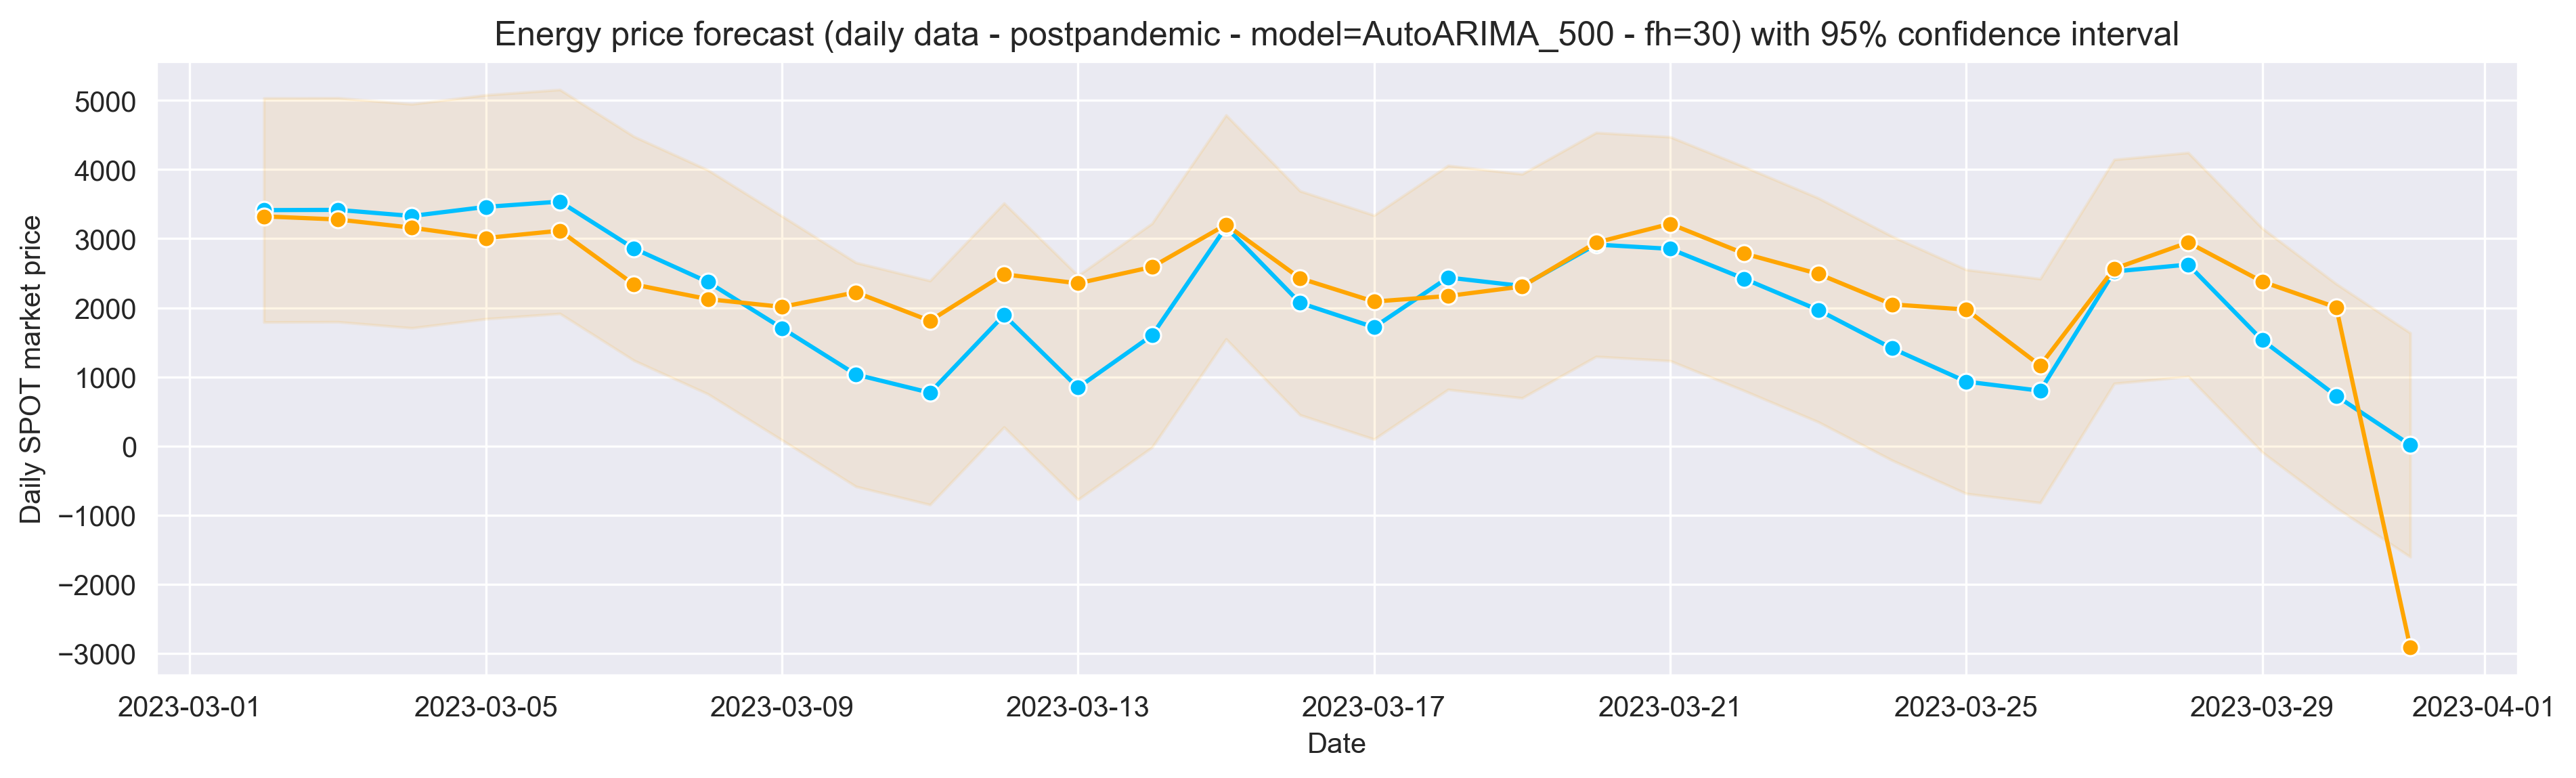

In [96]:
residuals = abs(y_pred-y_test).values
RMSFE = np.sqrt(sum([x**2 for x in residuals]) / len(residuals))
band_size = 1.96*RMSFE

if type(y_test.index) is pd.core.indexes.period.PeriodIndex:
    y_test.index = y_test.index.to_timestamp()
if type(y_pred.index) is pd.core.indexes.period.PeriodIndex:
    y_pred.index = y_pred.index.to_timestamp()

fig, ax = plt.subplots(figsize=(15,4))
sns.lineplot(data=y_test, color="deepskyblue", marker="o", ax=ax)
sns.lineplot(data=y_pred, color="orange", marker="o", ax=ax)
ax.fill_between(y_test.index, (y_test-band_size), (y_test+band_size), color='orange', alpha=.1)
ax.set_title(f"Energy price forecast (daily data - postpandemic - model=AutoARIMA_{best_window_length} - fh={forecasting_horizon}) with 95% confidence interval")
ax.set_xlabel('Date')
ax.set_ylabel('Daily SPOT market price')
plt.show()

In [97]:
forecaster.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  200
Model:               SARIMAX(2, 0, 2)   Log Likelihood               -1518.804
Date:                Wed, 05 Jul 2023   AIC                           3061.609
Time:                        17:56:31   BIC                           3101.188
Sample:                    08-14-2022   HQIC                          3077.626
                         - 03-01-2023                                         
Covariance Type:                  opg                                         
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
intercept                       64.7316     59.578      1.087      0.277     -52.038     181.501
clean_generation__pca0        -284.4215     88.420     -3.217      0.001    -457.722    -111.121
clean_generation__pca1         377.7399     88.799      4.254      0.000     203.697     551.783
clean_generation__pca2          64.2897    139.723      0.460      0.645    -209.562     338.141
traditional_generation__pca0   -65.9028     99.752     -0.661      0.509    -261.413     129.607
commodities__pca0              727.4010    208.608      3.487      0.000     318.537    1136.265
rest__DEMANDA_REAL             350.7549     73.123      4.797      0.000     207.437     494.073
ar.L1                            1.0532      0.238      4.424      0.000       0.587       1.520
ar.L2                           -0.0809      0.226     -0.358      0.720      -0.523       0.361
ma.L1                           -0.3009      0.240     -1.255      0.209      -0.771       0.169
ma.L2                           -0.2901      0.104     -2.785      0.005      -0.494      -0.086
sigma2                        2.348e+05   2.41e+04      9.745      0.000    1.88e+05    2.82e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 1.60
Prob(Q):                              0.90   Prob(JB):                         0.45
Heteroskedasticity (H):               0.52   Skew:                             0.18
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Postpandemic

### 6 months dataset

In [8]:
y_train, y_test, X_train, X_test = load_and_preprocess_daily_data_arima(start_index="2021-04-01", end_index="2023-03-31")

In [ ]:
cv_results_df = func.crossval_arima_sktime(y_train, X_train, window_lengths, step_size, fh, save_path="lab/models/daily/", save_name="arima_2y_60step_30fh_mase.pkl")

In [9]:
save_path = "lab/models/daily/"
cv_results_df = pd.read_pickle(save_path+"arima_2y_60step_30fh_mase.pkl")

In [10]:
cv_results_df_summary = func.crossval_summary_sktime(cv_results_df)
cv_results_df_summary

,model,mae,mase,fit_time
3,AutoARIMA_500,96.366585,1.695899,87.581615
1,AutoARIMA_300,298.71101,2.162655,147.963091
2,AutoARIMA_400,234.788633,2.548488,129.669448
0,AutoARIMA_200,424.356471,2.698293,97.405607


In [ ]:
best_window_length = int(cv_results_df_summary.iloc[0, 0].split("_")[1])
forecaster = AutoARIMA(maxiter=200)
forecaster.fit(y_train[best_window_length:], X=X_train, )

y_pred = forecaster.predict(X=X_test, fh=list(range(1, forecasting_horizon + 1)))
plot_series(y_test, y_pred, labels=["y", "y_pred"])
print(mean_absolute_error(y_test, y_pred))
print(mean_absolute_percentage_error(y_test, y_pred))
print(mean_absolute_scaled_error(y_test, y_pred, y_train=y_train[best_window_length:]))

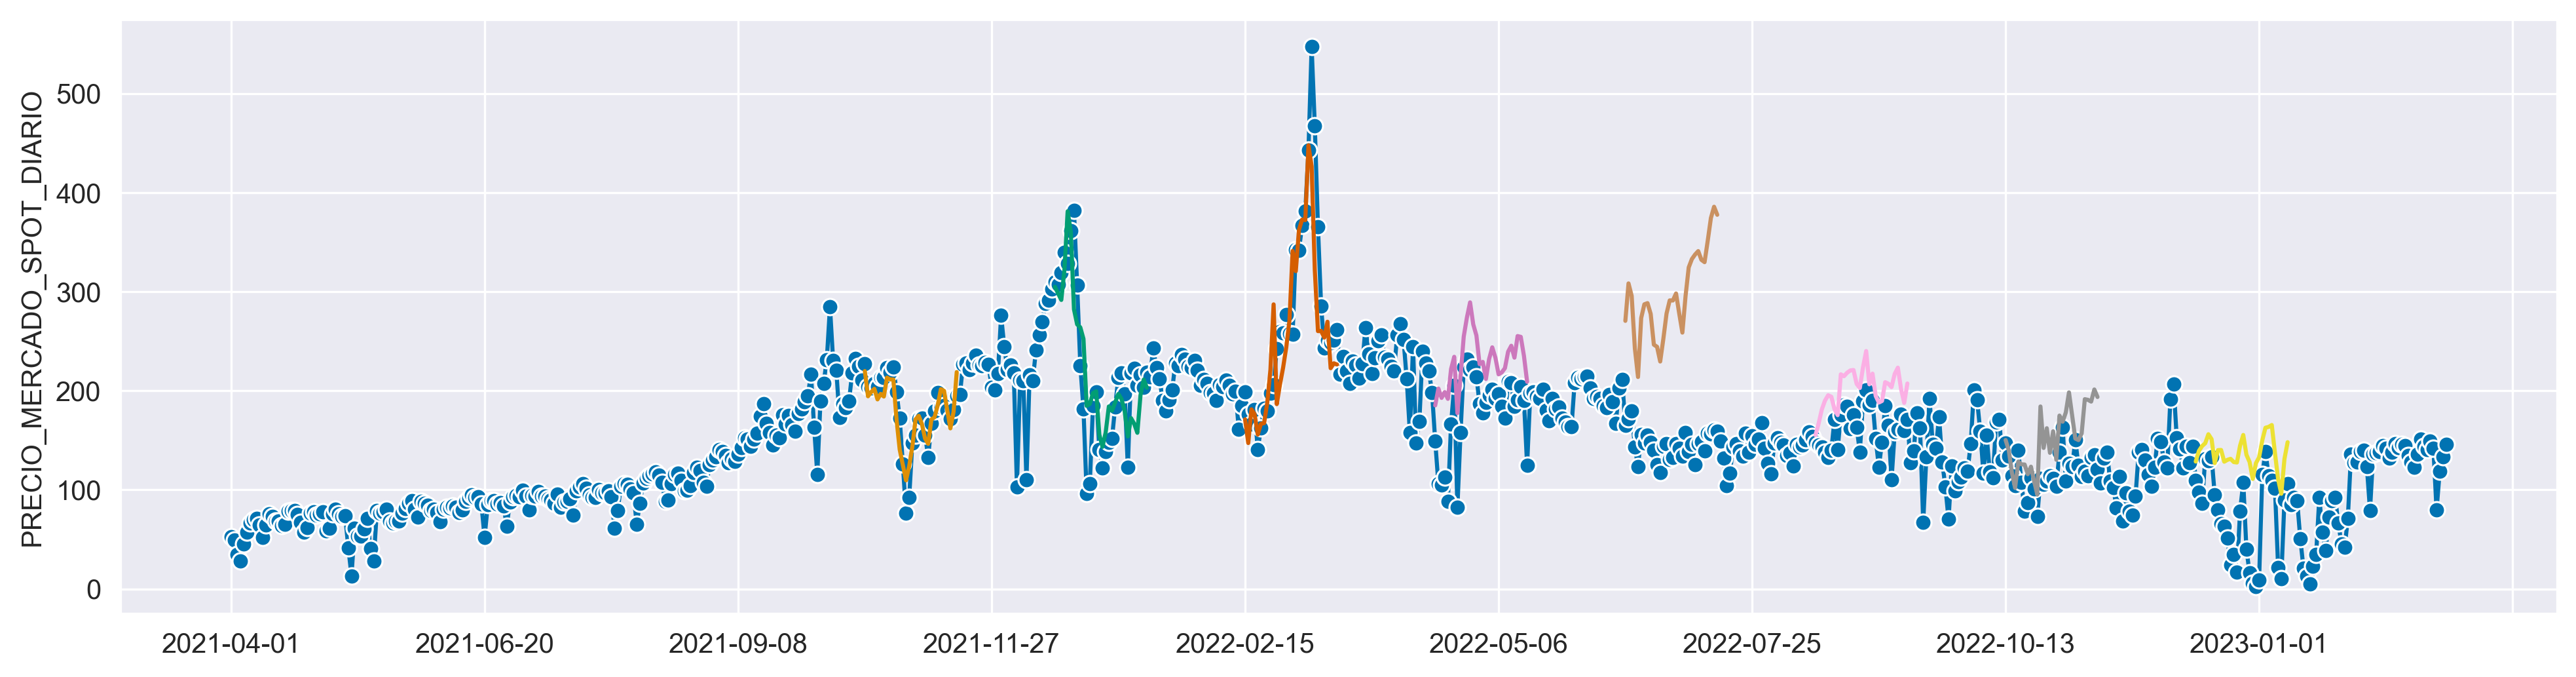

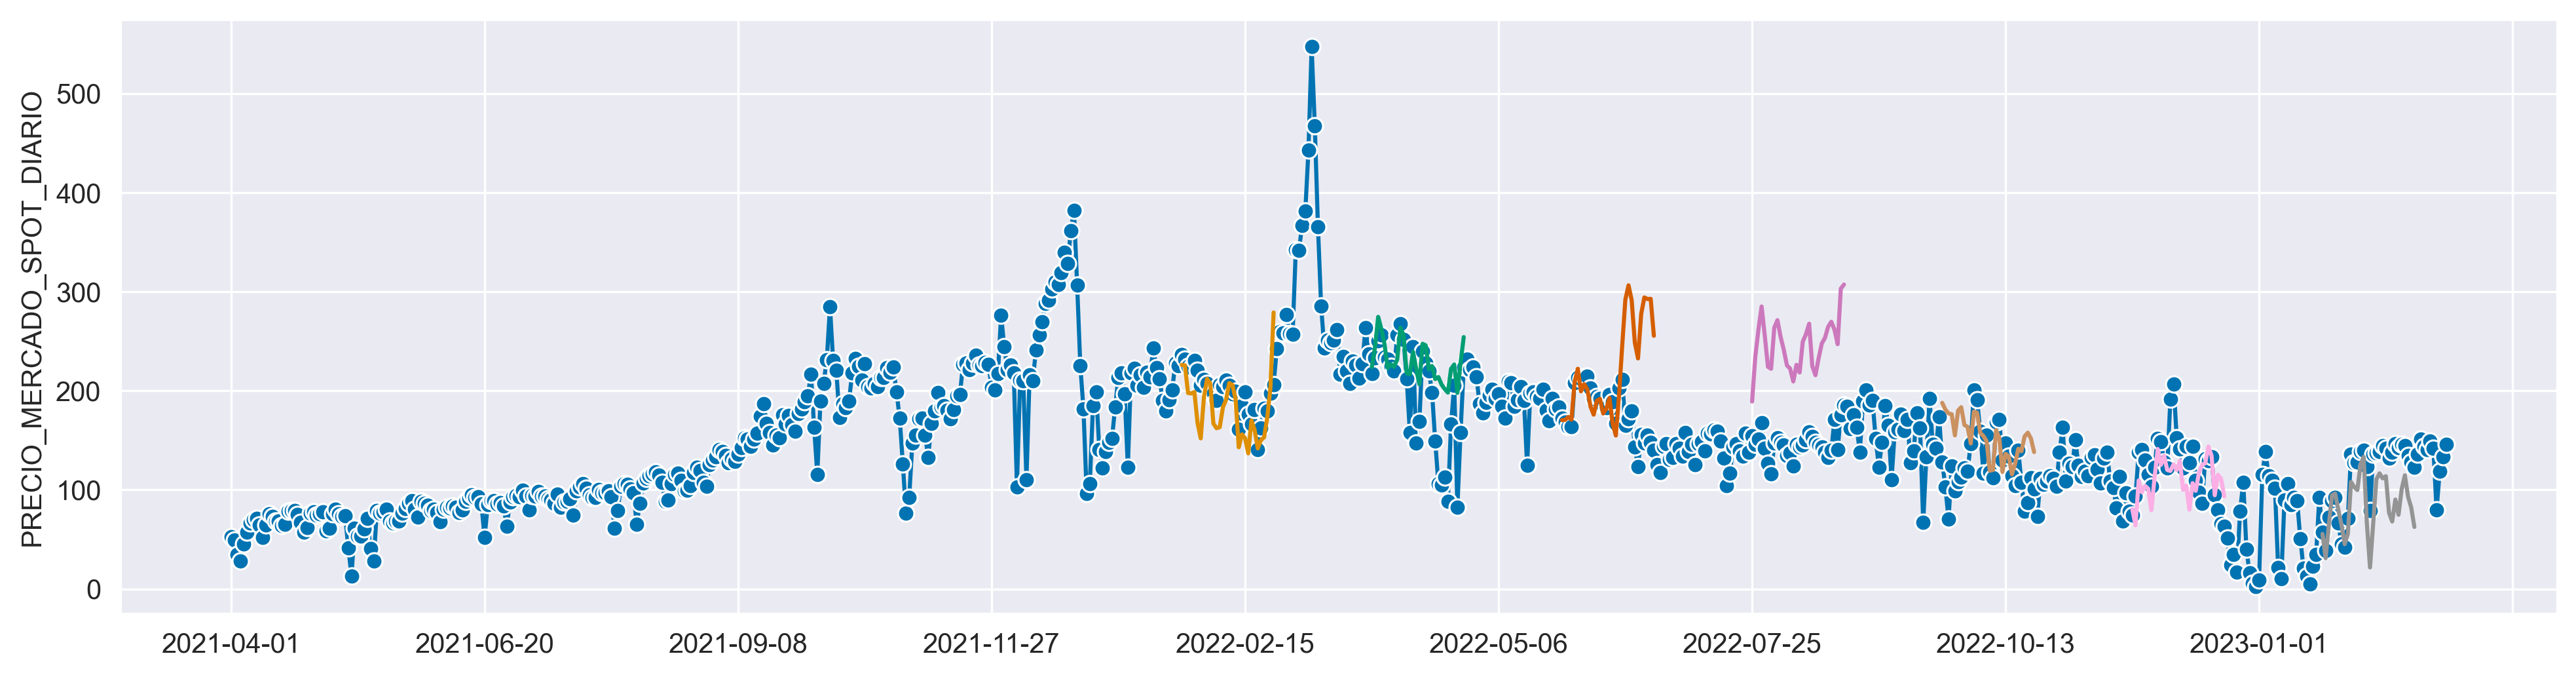

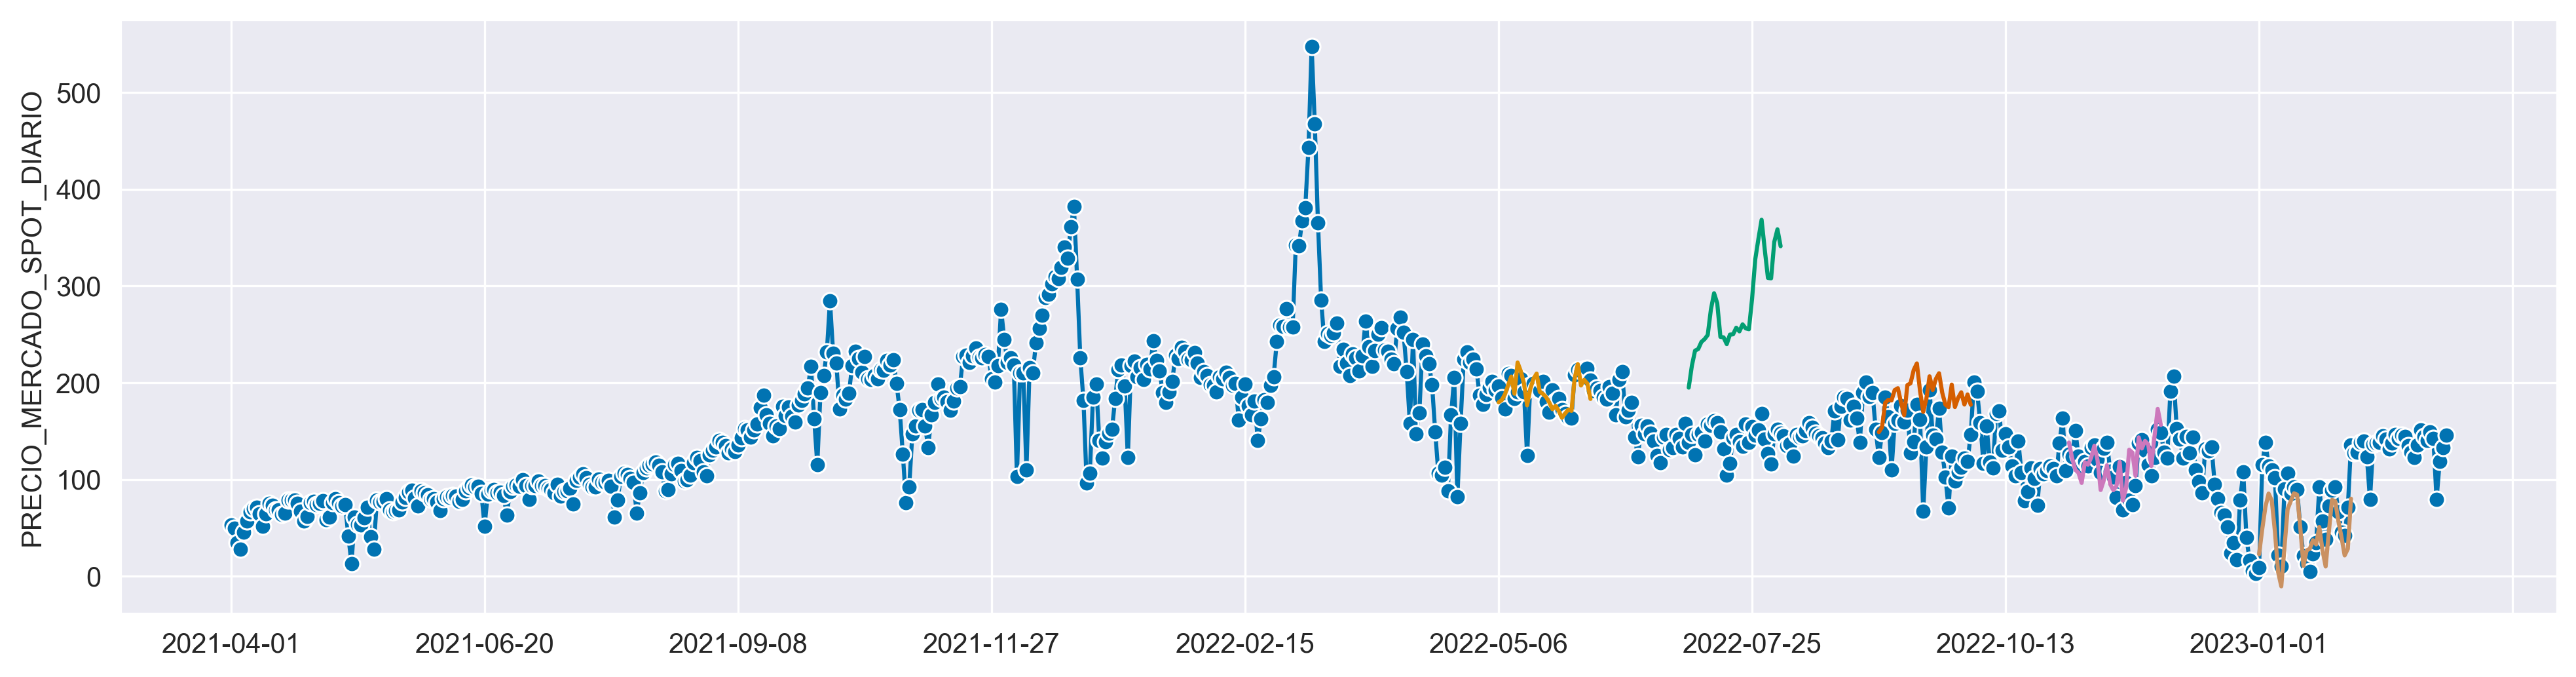

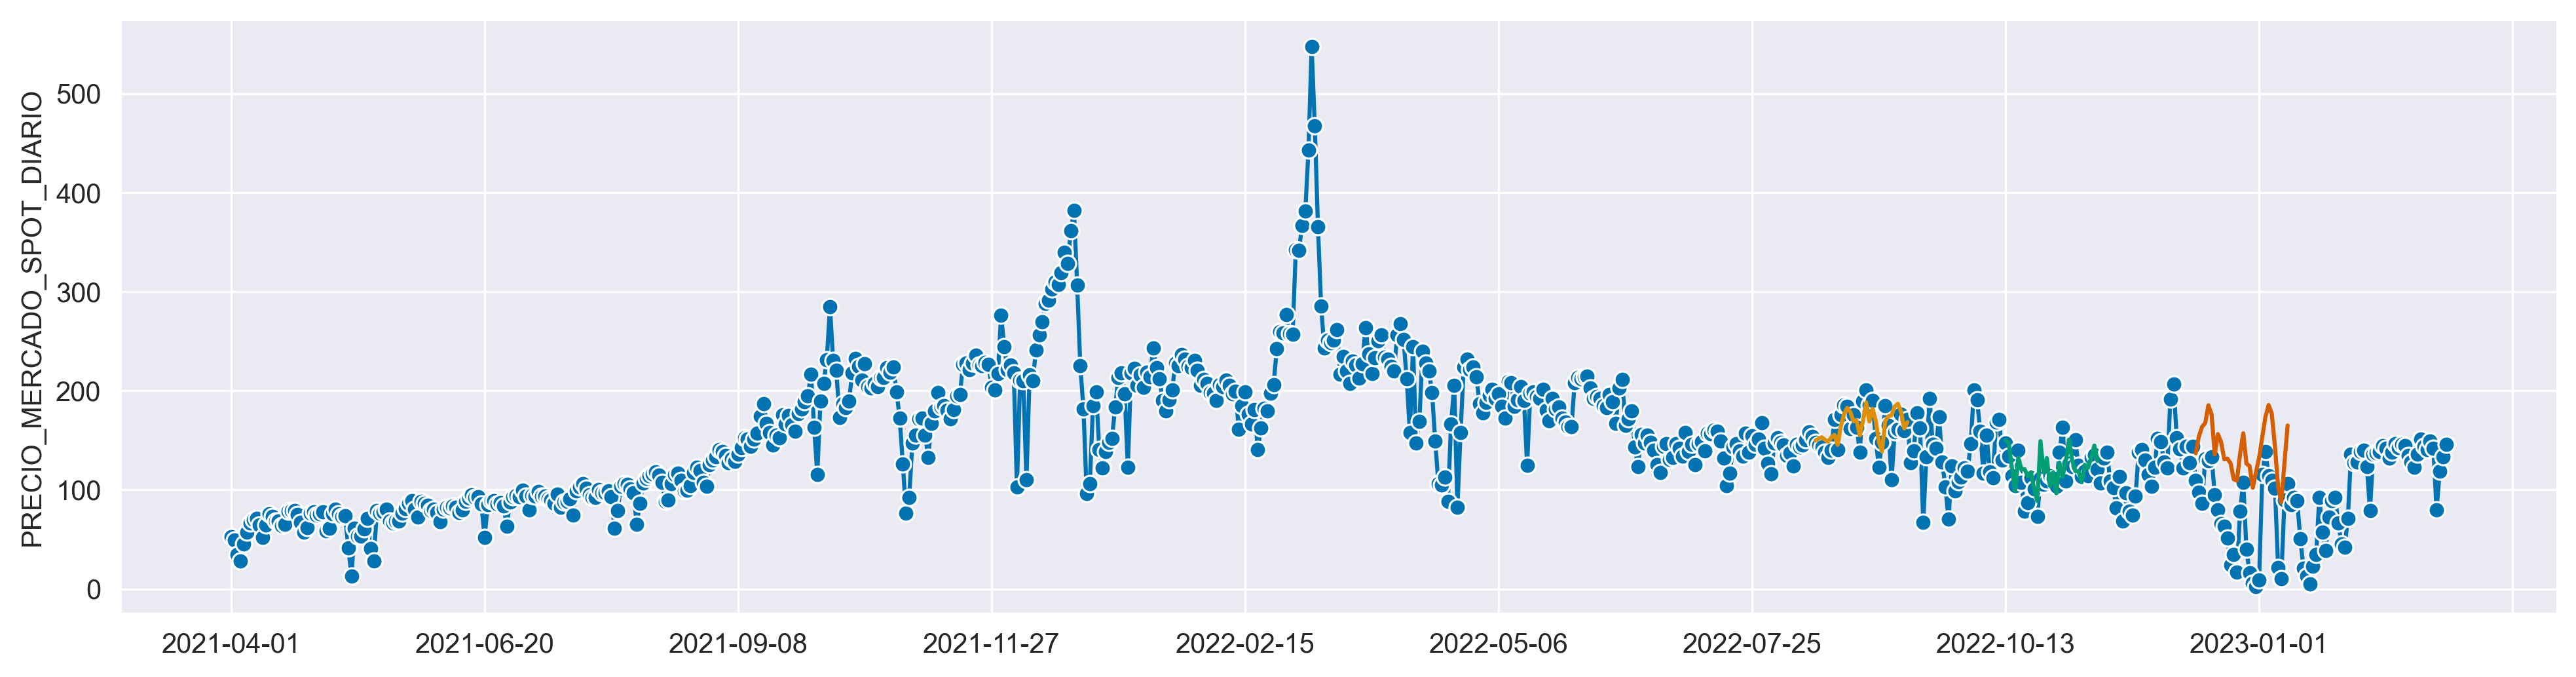

In [11]:
func.crossval_plot_series(y_train, cv_results_df)

#### Final model

Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals


20.012124562202043
0.4853224759956839
0.9112079691265241


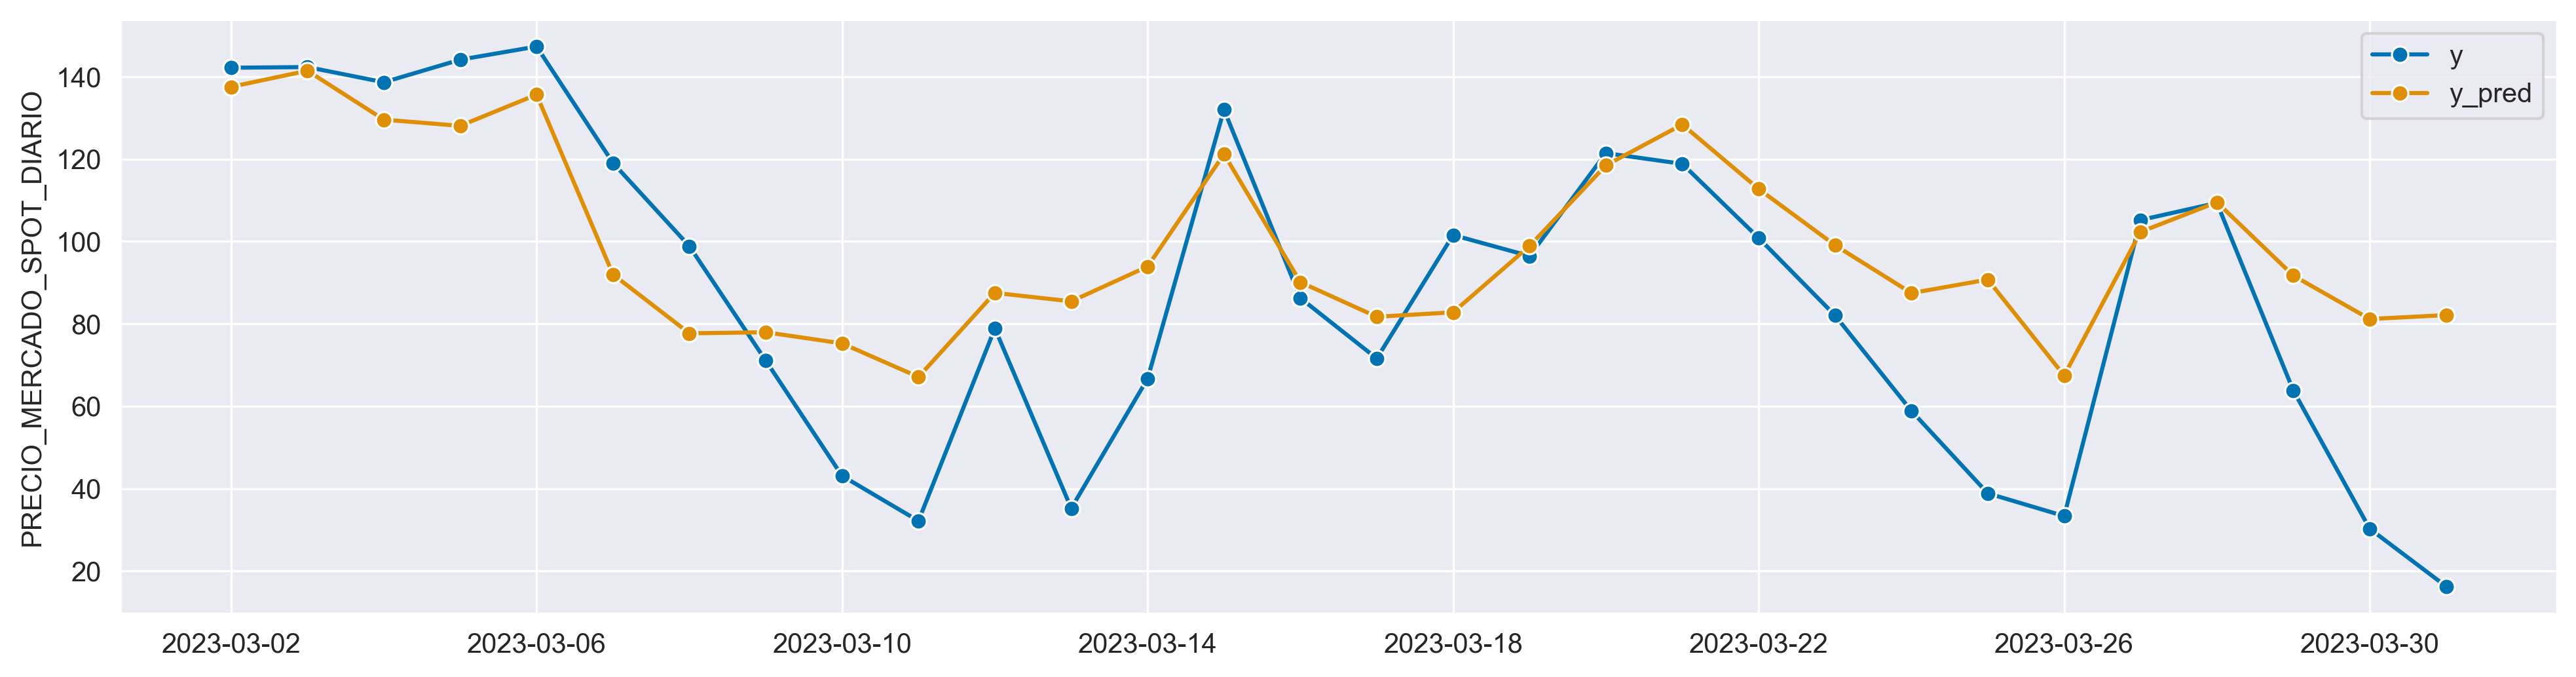

In [12]:
best_window_length = int(cv_results_df_summary.iloc[0, 0].split("_")[1])
forecaster = AutoARIMA(maxiter=200)
forecaster.fit(y_train[best_window_length:], X=X_train, )

y_pred = forecaster.predict(X=X_test, fh=list(range(1, forecasting_horizon + 1)))
plot_series(y_test, y_pred, labels=["y", "y_pred"])
print(mean_absolute_error(y_test, y_pred))
print(mean_absolute_percentage_error(y_test, y_pred))
print(mean_absolute_scaled_error(y_test, y_pred, y_train=y_train[best_window_length:]))

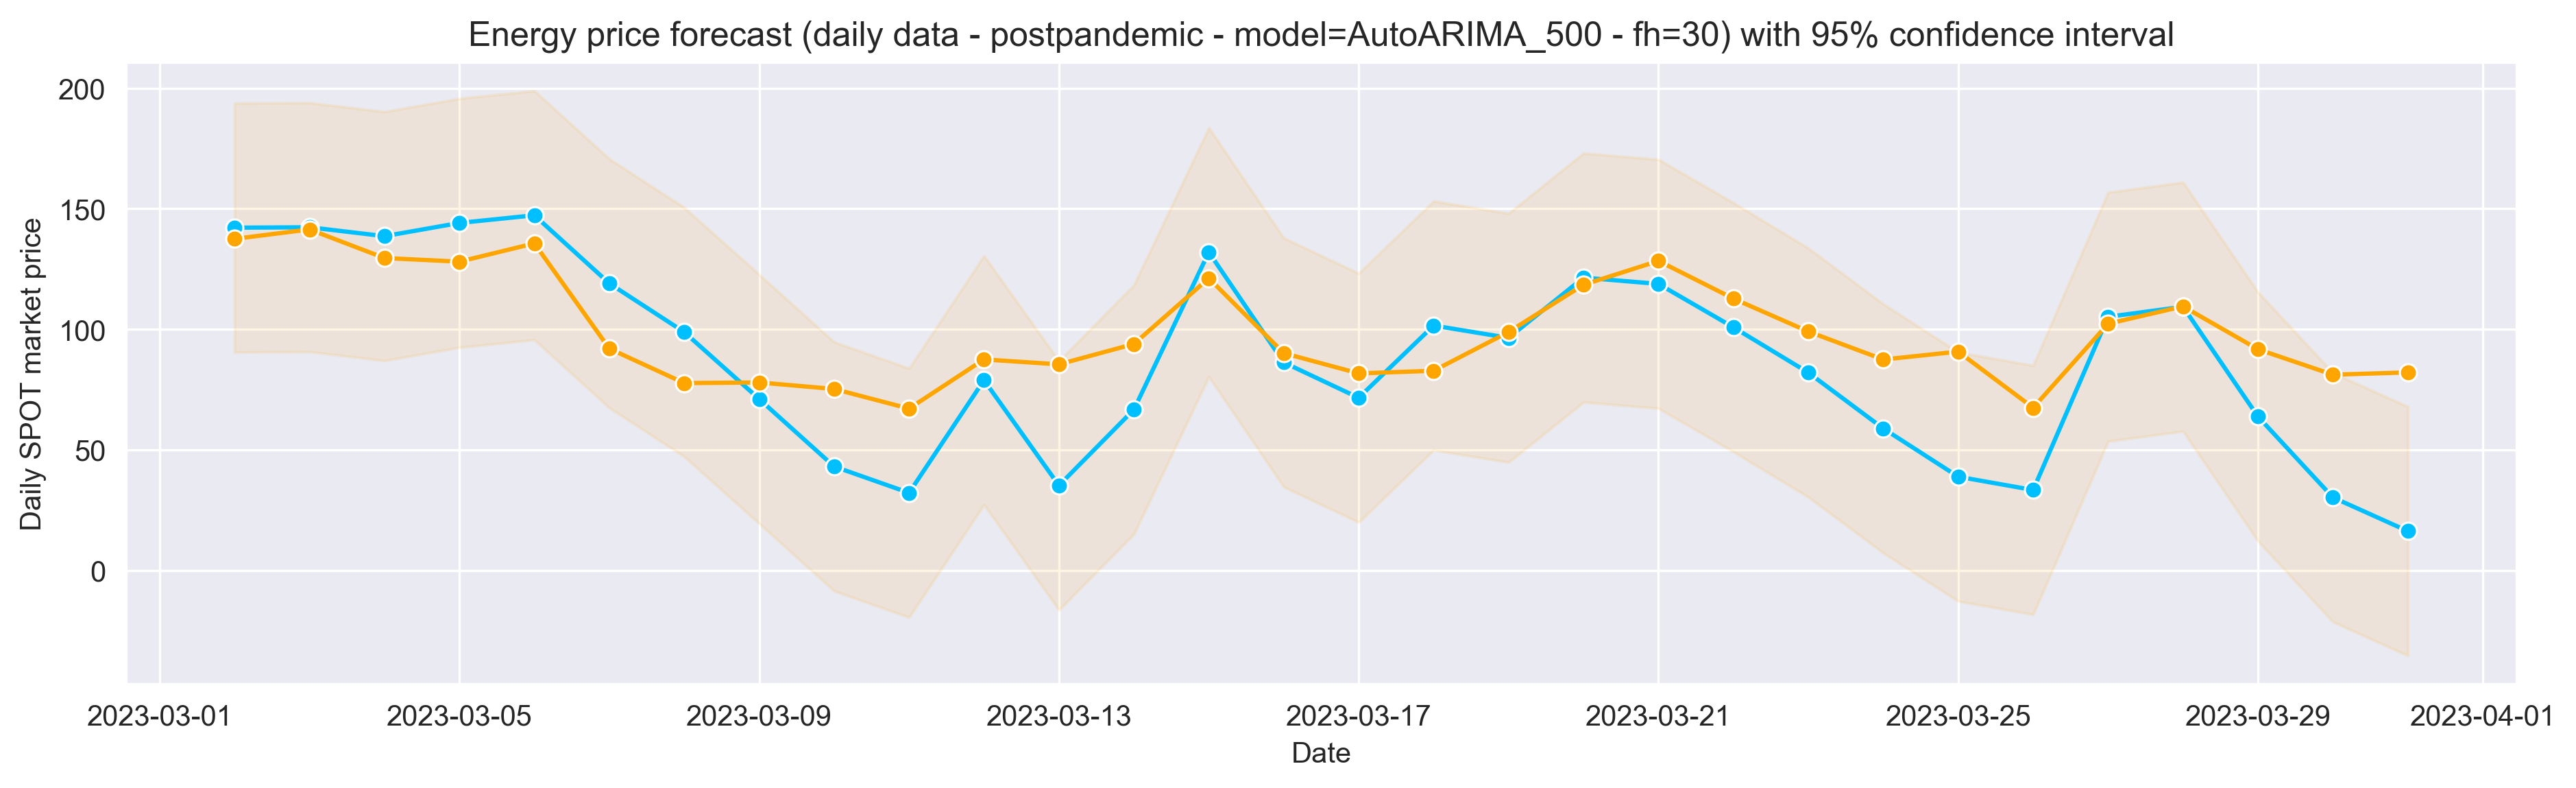

In [13]:
residuals = list(abs(y_pred-y_test))
RMSFE = np.sqrt(sum([x**2 for x in residuals]) / len(residuals))
band_size = 1.96*RMSFE

if type(y_test.index) is pd.core.indexes.period.PeriodIndex:
    y_test.index = y_test.index.to_timestamp()
if type(y_pred.index) is pd.core.indexes.period.PeriodIndex:
    y_pred.index = y_pred.index.to_timestamp()

fig, ax = plt.subplots(figsize=(15,4))
sns.lineplot(data=y_test, color="deepskyblue", marker="o", ax=ax)
sns.lineplot(data=y_pred, color="orange", marker="o", ax=ax)
ax.fill_between(y_test.index, (y_test-band_size), (y_test+band_size), color='orange', alpha=.1)
ax.set_title(f"Energy price forecast (daily data - postpandemic - model=AutoARIMA_{best_window_length} - fh={forecasting_horizon}) with 95% confidence interval")
ax.set_xlabel('Date')
ax.set_ylabel('Daily SPOT market price')
plt.show()

In [14]:
forecaster.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  200
Model:               SARIMAX(0, 0, 1)   Log Likelihood                -882.254
Date:                Sun, 25 Jun 2023   AIC                           1788.508
Time:                        13:29:31   BIC                           1828.088
Sample:                    08-14-2022   HQIC                          1804.526
                         - 03-01-2023                                         
Covariance Type:                  opg                                         
=====================================================================================================
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
DEMANDA_REAL                          0.0002   5.04e-05      4.574      0.000       0.000       0.000
GENERACIÓN_MEDIDA_EÓLICA             -0.0002   5.06e-05     -4.275      0.000      -0.000      -0.000
GENERACIÓN_MEDIDA_HIDRÁULICA         -0.0004      0.000     -3.322      0.001      -0.001      -0.000
GENERACIÓN_MEDIDA_NUCLEAR            -0.0003      0.000     -1.969      0.049      -0.001    -1.6e-06
GENERACIÓN_MEDIDA_SOLAR            6.379e-06   8.61e-05      0.074      0.941      -0.000       0.000
GENERACIÓN_MEDIDA_CICLO_COMBINADO  8.433e-05   6.29e-05      1.341      0.180   -3.89e-05       0.000
GENERACIÓN_MEDIDA_CARBÓN              0.0006      0.000      1.613      0.107      -0.000       0.001
DAILY_TTF_PRICE                       0.1177      0.103      1.147      0.251      -0.083       0.319
DAILY_COAL_PRICE                     -0.0668      0.084     -0.790      0.429      -0.232       0.099
CO2_EUA_PRICE                         0.7717      0.276      2.798      0.005       0.231       1.312
ma.L1                                 0.5401      0.061      8.882      0.000       0.421       0.659
sigma2                              403.0230     39.016     10.330      0.000     326.553     479.493
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                 4.06
Prob(Q):                              0.81   Prob(JB):                         0.13
Heteroskedasticity (H):               1.25   Skew:                            -0.21
Prob(H) (two-sided):                  0.36   Kurtosis:                         3.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Prepandemic

### 6 months dataset

In [15]:
y_train, y_test, X_train, X_test = load_and_preprocess_daily_data_arima(start_index="2018-04-01", end_index="2020-03-31")

In [ ]:
cv_results_df = func.crossval_arima_sktime(y_train, X_train, window_lengths, step_size, fh, save_path="lab/models/daily/", save_name="arima_2y_60step_30fh_mase_prepandemic.pkl")

In [16]:
save_path = "lab/models/daily/"
cv_results_df = pd.read_pickle(save_path+"arima_2y_60step_30fh_mase_prepandemic.pkl")

In [17]:
cv_results_df_summary = func.crossval_summary_sktime(cv_results_df)
cv_results_df_summary

,model,mae,mase,fit_time
2,AutoARIMA_400,16.881055,0.929604,197.504757
1,AutoARIMA_300,28.552497,1.117683,78.747226
0,AutoARIMA_200,33.762702,1.248828,97.493102
3,AutoARIMA_500,19.826049,1.88596,114.225986


#### Final model

Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood o

3.17412693982594
0.14002155257272694
0.8955487280277175


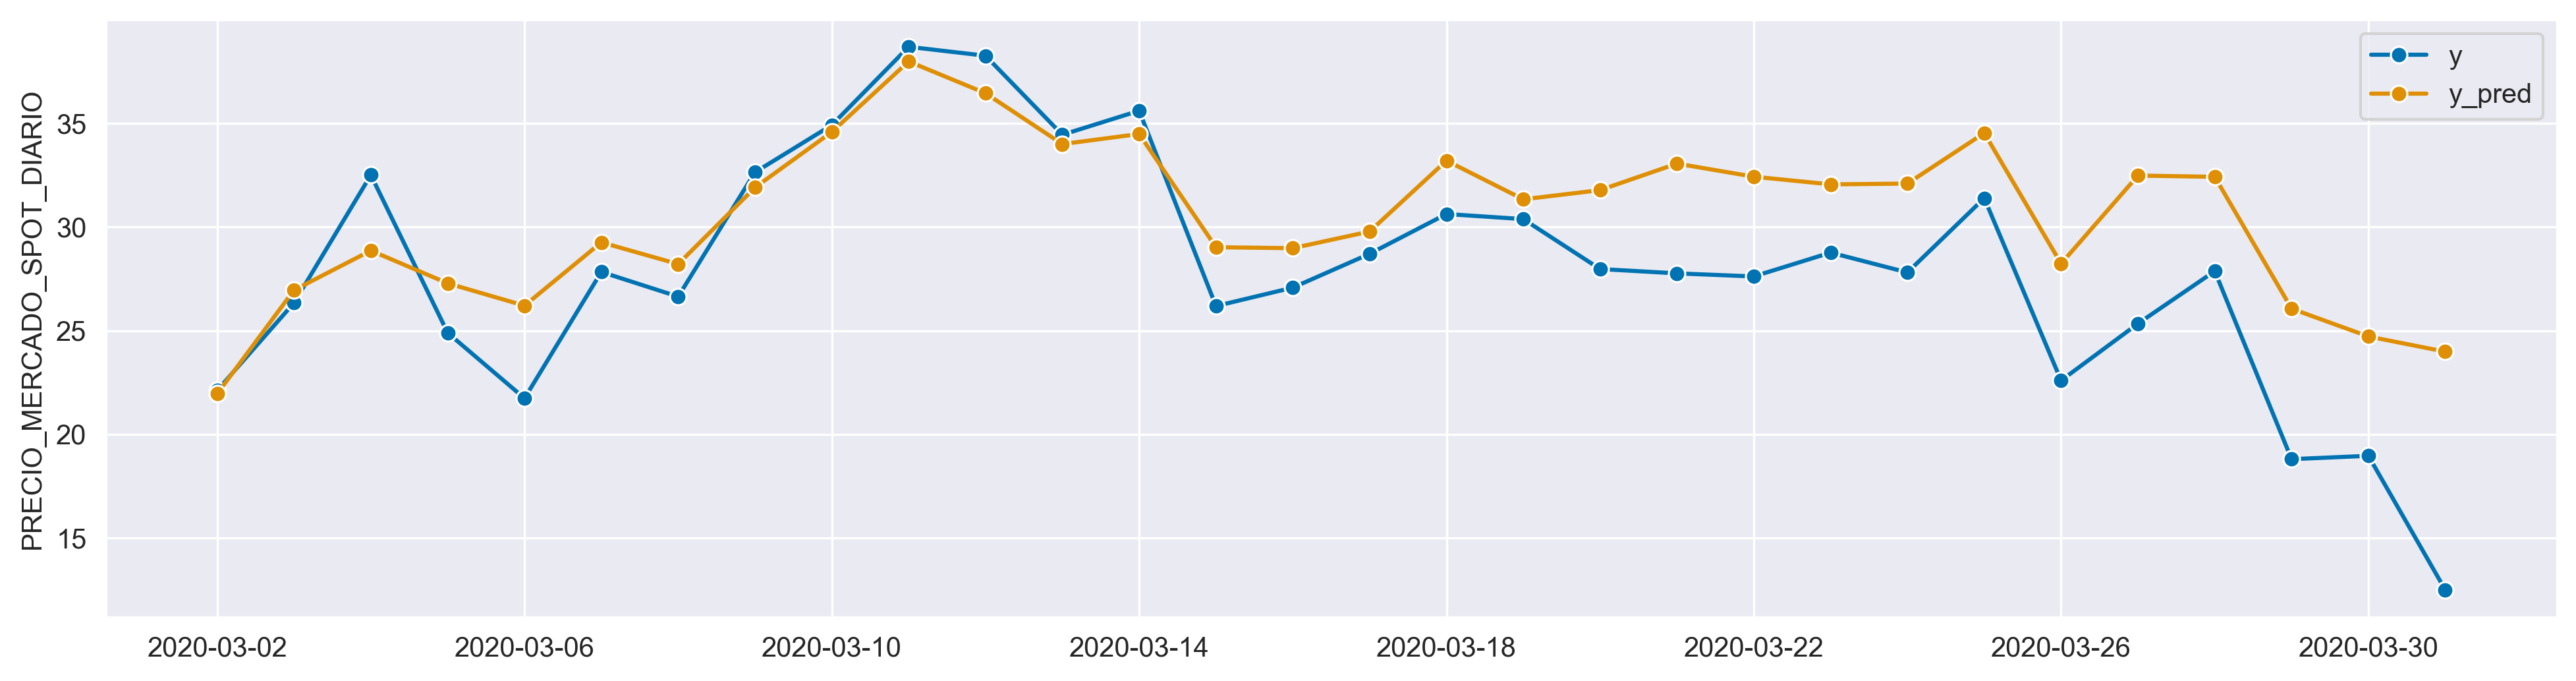

In [18]:
best_window_length = int(cv_results_df_summary.iloc[0, 0].split("_")[1])
forecaster = AutoARIMA()
forecaster.fit(y_train[best_window_length:], X=X_train)

y_pred = forecaster.predict(X=X_test, fh=list(range(1, forecasting_horizon + 1)))
plot_series(y_test, y_pred, labels=["y", "y_pred"])
print(mean_absolute_error(y_test, y_pred))
print(mean_absolute_percentage_error(y_test, y_pred))
print(mean_absolute_scaled_error(y_test, y_pred, y_train=y_train[best_window_length:]))

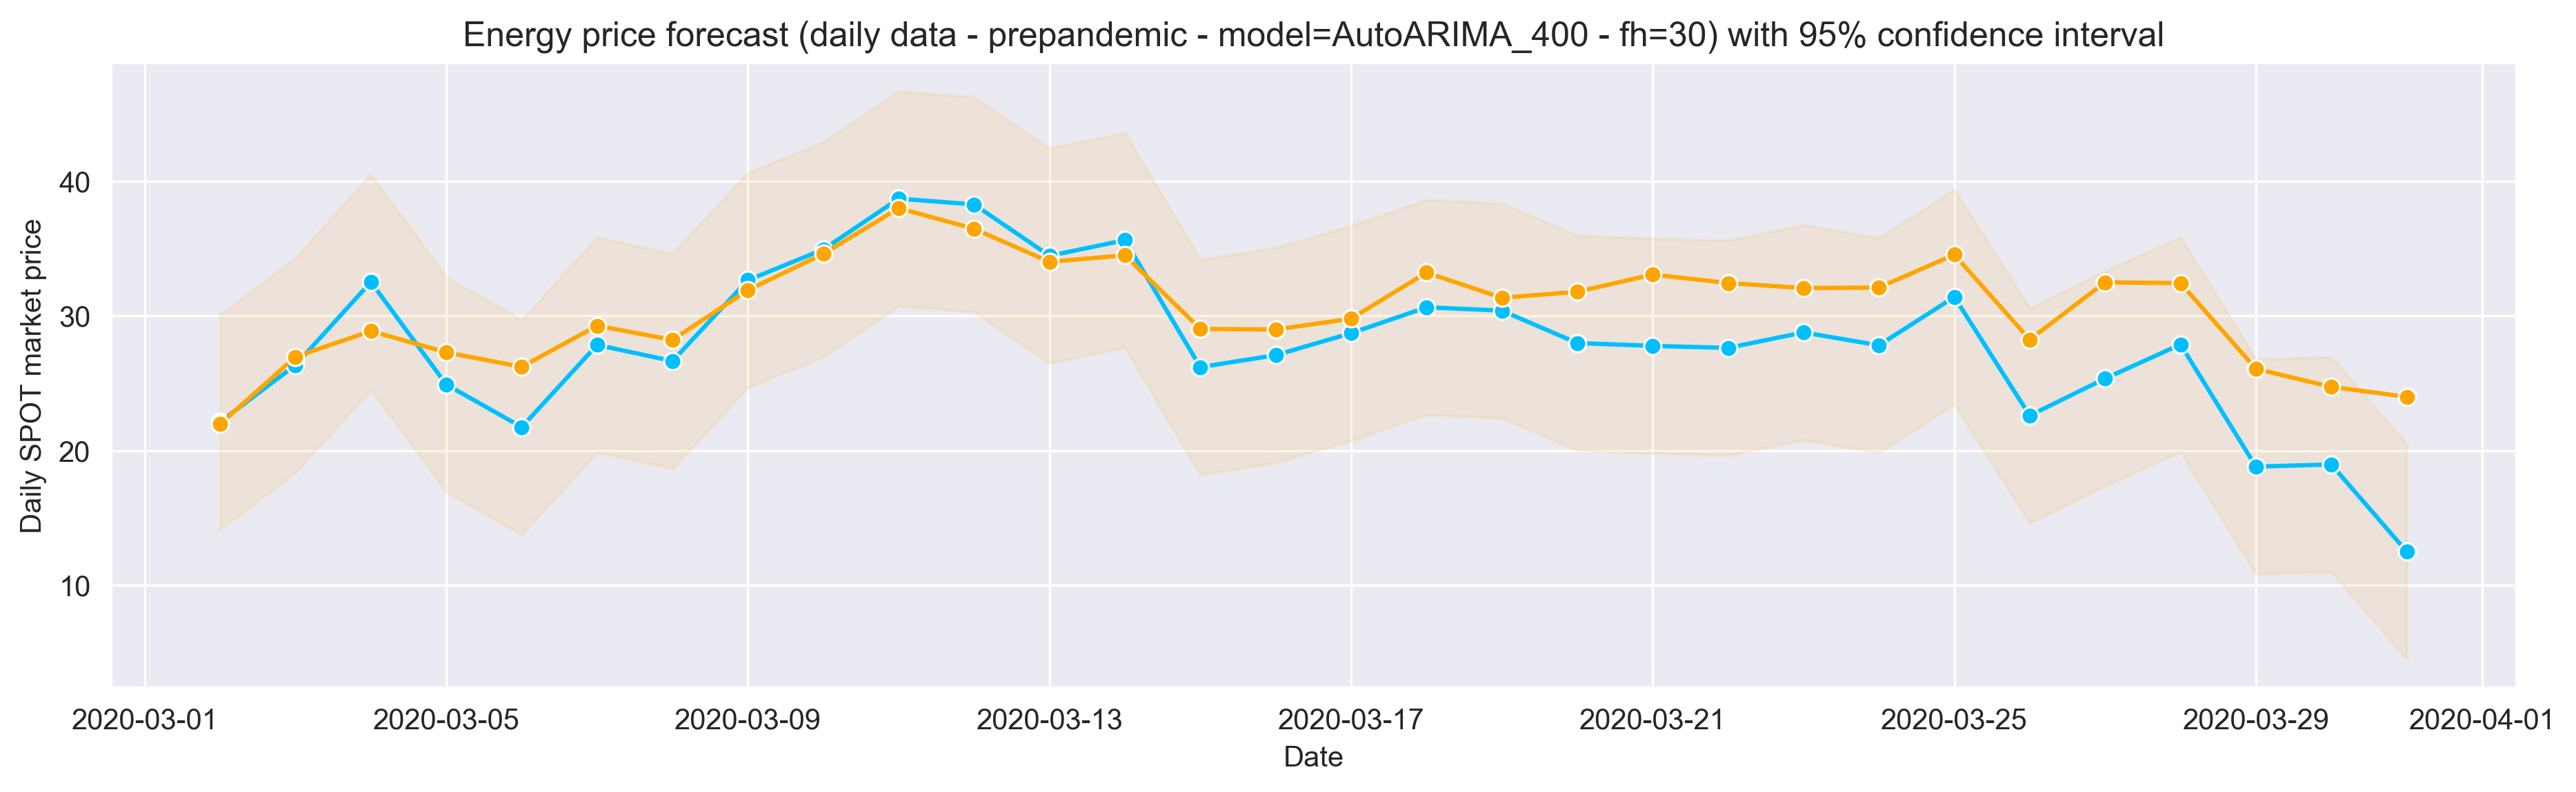

In [19]:
residuals = list(abs(y_pred-y_test))
RMSFE = np.sqrt(sum([x**2 for x in residuals]) / len(residuals))
band_size = 1.96*RMSFE

if type(y_test.index) is pd.core.indexes.period.PeriodIndex:
    y_test.index = y_test.index.to_timestamp()
if type(y_pred.index) is pd.core.indexes.period.PeriodIndex:
    y_pred.index = y_pred.index.to_timestamp()

fig, ax = plt.subplots(figsize=(15,4))
sns.lineplot(data=y_test, color="deepskyblue", marker="o", ax=ax)
sns.lineplot(data=y_pred, color="orange", marker="o", ax=ax)
ax.fill_between(y_test.index, (y_test-band_size), (y_test+band_size), color='orange', alpha=.1)
ax.set_title(f"Energy price forecast (daily data - prepandemic - model=AutoARIMA_{best_window_length} - fh={forecasting_horizon}) with 95% confidence interval")
ax.set_xlabel('Date')
ax.set_ylabel('Daily SPOT market price')
plt.show()

In [20]:
forecaster.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  301
Model:               SARIMAX(0, 1, 2)   Log Likelihood                -696.456
Date:                Sun, 25 Jun 2023   AIC                           1418.913
Time:                        13:29:59   BIC                           1467.062
Sample:                    05-06-2019   HQIC                          1438.182
                         - 03-01-2020                                         
Covariance Type:                  opg                                         
=====================================================================================================
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
DEMANDA_REAL                       3.337e-05   6.02e-06      5.545      0.000    2.16e-05    4.52e-05
GENERACIÓN_MEDIDA_EÓLICA          -3.569e-05   5.44e-06     -6.562      0.000   -4.63e-05    -2.5e-05
GENERACIÓN_MEDIDA_HIDRÁULICA       5.857e-06   1.94e-05      0.302      0.763   -3.21e-05    4.39e-05
GENERACIÓN_MEDIDA_NUCLEAR             0.0001   1.74e-05      8.417      0.000       0.000       0.000
GENERACIÓN_MEDIDA_SOLAR           -1.733e-05      2e-05     -0.867      0.386   -5.65e-05    2.18e-05
GENERACIÓN_MEDIDA_CICLO_COMBINADO  2.705e-05    9.7e-06      2.790      0.005    8.05e-06    4.61e-05
GENERACIÓN_MEDIDA_CARBÓN           8.634e-05   3.43e-05      2.521      0.012    1.92e-05       0.000
DAILY_TTF_PRICE                      -0.3121      0.410     -0.761      0.447      -1.116       0.492
DAILY_COAL_PRICE                     -0.2204      0.273     -0.806      0.420      -0.756       0.315
CO2_EUA_PRICE                         0.0202      0.385      0.053      0.958      -0.734       0.774
ma.L1                                -0.1857      0.044     -4.229      0.000      -0.272      -0.100
ma.L2                                -0.1334      0.036     -3.736      0.000      -0.203      -0.063
sigma2                                5.8900      0.391     15.080      0.000       5.124       6.656
===================================================================================
Ljung-Box (L1) (Q):                   0.25   Jarque-Bera (JB):               263.30
Prob(Q):                              0.62   Prob(JB):                         0.00
Heteroskedasticity (H):               2.89   Skew:                            -0.12
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""